In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import pickle
from itertools import product

import numpy as np
import pandas as pd
import tqdm.auto as tqdm

import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
repo_dir = Path('../..')

In [4]:
if str(repo_dir) not in sys.path:
    sys.path.append(str(repo_dir))
    
from analysis.curve_fitting.src.fitting_functions import LOSS_FUNCTIONS
from analysis.curve_fitting.src.utils import apply_filters, load_yaml, convert_loss_parameters, convert_loss_parameters_batch

from visualization.src.utils import COLOR_PALETTES, set_ticks, save_figs
from visualization.src.visualize import plot_reg, plot_reg_bivariate, plot_confidence_intervals



In [5]:
args = {
    'results_csv': repo_dir / 'results' / 'benchmark_scores_local.csv',
}

In [6]:
results_csv = args['results_csv']

df_results = pd.read_csv(results_csv)
df_results['total_flops'] = df_results['flops'] * df_results['n_samples_seen']

## Load Experiment Configuration

In [7]:
analysis_dir = repo_dir / 'analysis'
config_dir = analysis_dir / 'curve_fitting/configs/region'
results_dir = analysis_dir / 'curve_fitting/fitting_results'
# results_dir = analysis_dir / 'curve_fitting/fitting_results_region'

In [8]:
region = [
    'v1',
    'v2',
    'v4',
    'it',
    'behavior',
    'avg',
]

model_groups = ['group1', 'group2']

In [9]:
all_configs = {}

for r, g in product(region, model_groups):
    yaml_config = config_dir / f'{r}/{r}_{g}.yaml'
    all_configs[f"{r}_{g}"] = load_yaml(yaml_config)


In [10]:
L_fit_dict = {key: config['fitting_parameters']['loss_function'] for key, config in all_configs.items()}
L_viz_dict = {key: config['visualization']['loss_function'] for key, config in all_configs.items()}
x_scale_dict = {key: float(config['fitting_parameters']['X_scaler']) for key, config in all_configs.items()}



## Apply Data Filters

In [11]:
all_df = {
    name: apply_filters(df_results, config.get('data_filters', {}))
    for name, config in all_configs.items()
}

## Load Fitting Results

In [12]:
optimized_params_dict = {}
opt_params_boot_dict = {}

for exp_name in all_configs.keys():
    with open(results_dir / f'region_{exp_name}' / 'results.pkl', 'rb') as f:
        results = pickle.load(f)

    L_fit = L_fit_dict[exp_name]
    L_viz = L_viz_dict[exp_name]
    optimized_params_dict[exp_name] = convert_loss_parameters(results['optimized_parameters'], L_fit, L_viz)

    # Convert bootstrapped parameters
    opt_params_boot = results['optimized_parameters_bootstrapped']
    opt_params_boot_dict[exp_name] = convert_loss_parameters_batch(
        params=opt_params_boot,
        src_loss=L_fit,
        dst_loss=L_viz
    )

/Users/akgokce/Documents/brain/scaling-primate-vvs/visualization/fig5/../../analysis/curve_fitting/src/utils/fitting.py:163: RuntimeWarning: overflow encountered in exp
  E, A = np.exp(e), np.exp(a)


## Bootstrapped Confidence Intervals for Gains

In [13]:
df_gains = []


for exp_name, opt_params_boot in opt_params_boot_dict.items():
    reg, model_group = exp_name.split('_')
    for opt_params in opt_params_boot:
        if model_group == 'group1':
            E, A, alpha = opt_params
            lambda_ = None
        else:
            E, A, lambda_, alpha = opt_params
        gain = A * 10 ** (alpha)
        df_gains.append(
            {
                'region': reg,
                'model_group': model_group,
                'E': E,
                'A': A,
                'lambda': lambda_,
                'alpha': alpha,
                'gain': gain
            }
        )

df_gains = pd.DataFrame(df_gains)
df_gains

,region,model_group,E,A,lambda,alpha,gain
0,v1,group1,0.741763,1.371328e-01,NaN,-0.196816,8.716175e-02
1,v1,group1,0.000019,8.218408e-01,NaN,-0.008293,8.062965e-01
2,v1,group1,0.736262,1.199334e-01,NaN,-0.157676,8.341887e-02
3,v1,group1,0.000025,8.278427e-01,NaN,-0.009083,8.107078e-01
4,v1,group1,0.695830,1.658515e-01,NaN,-0.103751,1.306076e-01
...,...,...,...,...,...,...,...
11995,avg,group2,0.575113,1.182548e+04,4.288706,-1.047686,1.059578e+03
11996,avg,group2,0.567874,7.705074e+03,4.220121,-1.013864,7.462986e+02
11997,avg,group2,0.565480,8.560883e+03,4.201139,-1.028204,8.022597e+02
11998,avg,group2,0.567089,5.391983e+03,4.224604,-0.976205,5.695646e+02


In [14]:
E, A, alpha = optimized_params_dict['avg_group1']
avg_gain_group1 = A * 10 ** (alpha)


E, A, lambda_, alpha = optimized_params_dict['avg_group2']
avg_gain_group2 = A * 10 ** (alpha)

## Visualize

#### Plotting settings

In [15]:
x_extend = 1.1
X_str = r'$$\tilde{C}$$'
linewidth = 3.0
alpha_scatter = 0.2
alpha_ci = 0.2
alpha_fit = 1.0
fig_multiplier = 0.75
figsize = (24, 12)
figsize = (fig_multiplier * figsize[0], fig_multiplier * figsize[1])

color_palette_models = COLOR_PALETTES['models']
color_palette_regions = COLOR_PALETTES['regions']
color_1, color_2 = color_palette_models[0], color_palette_models[-1]

In [16]:
regionNames = {
    'v1': 'V1',
    'v2': 'V2',
    'v4': 'V4',
    'it': 'IT',
    'behavior': 'Behavioral',
}

#### Plot

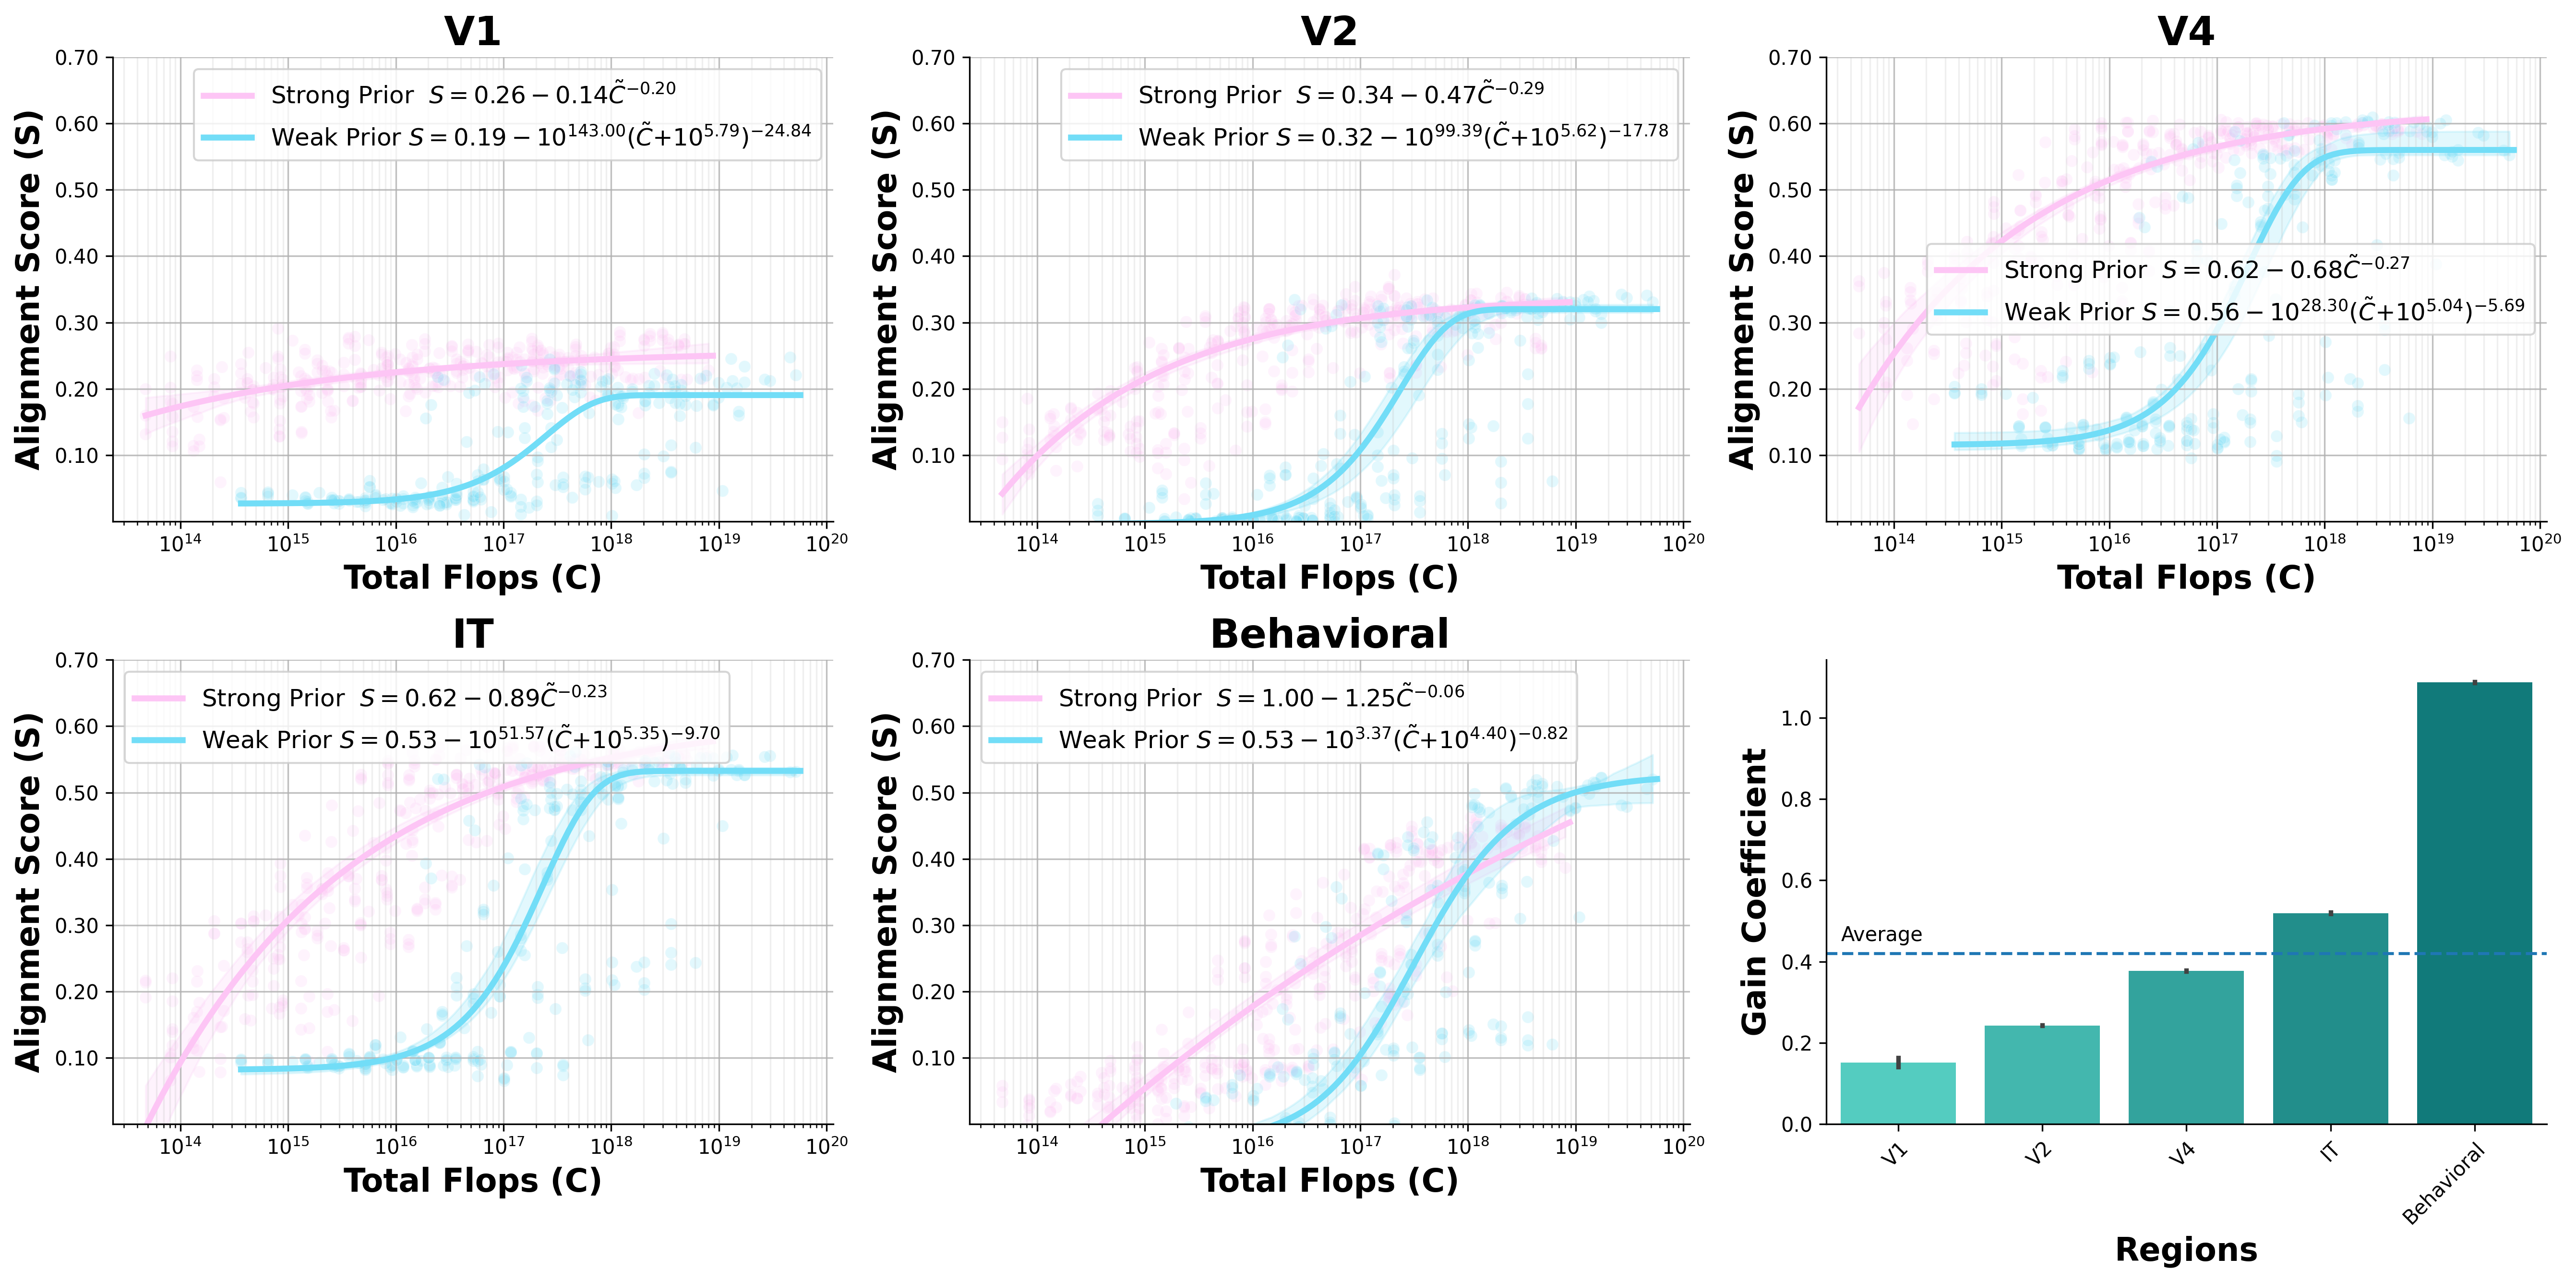

In [17]:
fig, axes = plt.subplots(2, 3, figsize=figsize, dpi=300)
for idx, reg in enumerate(region[:-1]):
    ax = axes.flatten()[idx]

    ### Group 11
    exp_name = f'{reg}_group1'
    df_region = all_df[exp_name]
    optimized_params_neuro = optimized_params_dict[exp_name]
    opt_params_boot_neuro = opt_params_boot_dict[exp_name]
    L = LOSS_FUNCTIONS[L_viz_dict[exp_name]]
    x_scaler = x_scale_dict[exp_name]
    X = df_region.total_flops.values / x_scaler
    
    color = color_1
    sns.scatterplot(data=df_region, x='total_flops', y='score', ax=ax, color=color, alpha=alpha_scatter)
    plot_reg(X, optimized_params_neuro, L, ax, color=color, x_extend=x_extend, linestyle='-', X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth, legend=False, alpha=alpha_fit)
    plot_confidence_intervals(X, opt_params_boot_neuro, L, ax, color=color, x_scaler=x_scaler, alpha=alpha_ci, percentile=95.0, invert_y=True)

    ### Behavioral
    exp_name = f'{reg}_group2'
    df_region = all_df[exp_name]
    optimized_params_behavior = optimized_params_dict[exp_name]
    opt_params_boot_behavior = opt_params_boot_dict[exp_name]
    L = LOSS_FUNCTIONS[L_viz_dict[exp_name]]
    x_scaler = x_scale_dict[exp_name]
    X = df_region.total_flops.values / x_scaler
    
    
    color = color_2
    sns.scatterplot(data=df_region, x='total_flops', y='score', ax=ax, color=color, alpha=alpha_scatter)
    plot_reg(X, optimized_params_behavior, L, ax, color=color, x_extend=x_extend, linestyle='-', X_str=X_str, x_scaler=x_scaler, show_x_scaler=False, linewidth=linewidth, legend=False, alpha=alpha_fit)
    plot_confidence_intervals(X, opt_params_boot_behavior, L, ax, color=color, x_scaler=x_scaler, alpha=alpha_ci, percentile=95.0, invert_y=True)


    ### Formatting
    ax.set_xscale('log')
    ax.set_ylim(0, 0.5)
    ax.set_xlabel('FLOPs')
    ax.set_ylabel('Alignment')
    ax.set_xlabel('Total Flops (C)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Alignment Score (S)', fontsize=16, fontweight='bold')
    ax.set_title(regionNames[reg], fontsize=20, fontweight='bold')
    ax = set_ticks(ax, xticks_mode='log', yticks_mode=None, yticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

    ### Legend
    handles, labels = ax.get_legend_handles_labels()
    labels = [
        'Strong Prior  ' + labels[0],
        'Weak Prior '  + labels[1]
    ]
    ax.legend(handles, labels, fontsize=12)

    ax.spines[['right', 'top']].set_visible(False)
    
    

### Gains
ax = axes.flatten()[-1]

df_plot = df_gains[df_gains['model_group'] == 'group1']
df_plot = df_plot[df_plot['region'] != 'avg']
df_plot.region = df_plot.region.map(regionNames)
sns.barplot(data=df_plot, hue='region', x='region', y='gain', ax=ax, palette=color_palette_regions, errorbar=('ci', 95))

avg = avg_gain_group1
ax.axhline(avg, 0, 1, linestyle='--', label='Average')
ax.text(0.02, avg+0.03, "Average", transform=ax.get_yaxis_transform() )

ax.legend().remove()
ax.set_xlabel('FLOPs')
ax.set_ylabel('Alignment')
ax.set_xlabel('Regions', fontsize=16, fontweight='bold')
ax.set_ylabel(r'Score Gain Coefficient per 10$\times$ FLOPS', fontsize=16, fontweight='bold')
ax.set_ylabel('Gain Coefficient', fontsize=16, fontweight='bold')
# ax.set_title('Average', fontsize=20, fontweight='bold')
# ax = set_ticks(ax, xticks_mode='linear', yticks_mode=None, yticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1])
ax.spines[['right', 'top']].set_visible(False)
ax.grid(False)

ticks = ax.get_xticks()
labels = ax.get_xticklabels()
ax.set_xticks(ticks, labels, rotation=45, ha='right', rotation_mode='anchor')
    
    

    
plt.tight_layout()



figures_dir = '../figures'
fig_name = 'fig5_regions_compare'
formats = ['pdf', 'png', 'svg']
save_figs(figures_dir, fig_name, formats=formats)
